# Introduction - Diabetes Patient Hospital Readmissions

Hospital readmissions are currently a major problem in the healthcare industry from both a financial and patient outcome standpoint. By finding patients that are most at risk for readmission and changing their care plan accordingly, hospitals will be able to save millions of dollars and the lives of patients.

In this analysis, we have been assigned the task of predicting whether or not a diabetes patient will need to be readmitted to the hospital based on certain features of that patient, including medical history, prescriptions and demographic information. This dataset includes 10 years of data (1999-2008) from 130 hospitals in the US with over 50 features, including the patient outcome, defined as whether or not there was a readmission. The aim of this analysis is to answer two main questions:

* What features are most important to predicting whether or not a diabetes patient will be readmitted to the hospital?
* How well can we predict whether or not a diabetes patient will be readmitted to the hospital?

In this notebook, we analyze and clean each feature in the dataset and begin predicting what we believe will be most important to determining a patient's readmission risk. We will later use this clean dataset to run different classification models and choose the model that best classifies readmission.

![hospital_beds](images/hosp_beds.jpg)

<a href="https://www.freepik.com/vectors/background">Background vector created by katemangostar - www.freepik.com</a>

## Variable Descriptions

Variable Descriptions:

**Encounter ID**: unique identifier of an encounter

**Patient_nbr**: unique identifier of a patient

**Race**: race of patient--Caucasian, Asian, African American, Hispanic, Other

**Gender**: gender of patient

**Age**: age of patient grouped into 10-year intervals

**Weight**: weight of patient in pounds, grouped into 25-pound intervals

**Admission Type ID**: type of admission identifier corresponding to distinct values 1-8.

**Discharge Disposition ID**: type of discharge identifier correspondig to distinct values 1-30.

**Admission Source ID**: type of admission source identifier corresponding to distinct values 1-26.

**Time in Hospital**: integer number of days between admission and discharge

**Payer Code**: patient's payer identifier corresponding to 23 distinct values

**Medical Specialty**: specialty of the admitting physician

**Number of lab procedures**: number of lab tests performed during the encounter

**Number of procedures**: number of procedures other than lab tests performed during the encounter

**Number of medications**: number of distinct medications administered during the encounter

**Number of outpatient visits**: number of outpatient visits of the patient in the year preceding the encounter

**Number of emergency visits**: number of emergency visits of the patient in the year preceding the encounter

**Number of inpatient visits**:number of inpatient visits of the patient in the year preceding the encounter

**Diagnosis 1**: the first 3 digits of the ICD9 code of the primary diagnosis

**Diagnosis 2**: the first 3 digits of the ICD9 code of the secondary diagnosis

**Diagnosis 3**: the first 3 digits of the ICD9 code of the additional secondary diagnosis

**Number of diagnoses**: the number of diagnoses of the patient

**Glucose serum test**: the range of the test result or if the test wasn't taken-- >200, >300, normal, or none if not taken

**A1c test result**: the range of the test result or if the test wasn't taken-- >8 if greater than 8%, >7 if greater than 7%, normal if less than 7%, or none if not taken

**Change of medications**: if there was a change in diabetic medications, whether dosage or generic name

**Diabetes medications**: if there was any diabetic medication prescribed

**24 medications--metformin, repaglinide, nateglinide, chlorpropamide,glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone,rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone,metformin-rosiglitazone, and metformin-pioglitazone**: 
indicates if the drug was prescribed and if there was a change is dosage--up if the dosage was increased, down if decreased, steady if dosage did not change, and no if drug was not prescribed

**Readmitted**: whether or not a patient was readmited and the days to readmission--<30 if readmitted in less than 30 days, >30 if readmitted in more than 30 days, no if not readmitted

## Model Evaluation Metrics

**Accuracy**: out of all the predictions our model made, what percentage correctly predicted whether a patient will not be readmitted.

**Precision**: When the model predicted someone would be readmitted, how many times was the patient actually readmitted.

**Recall**: Of all the patients that were actually readmitted, what percentage of them did our model correctly predict the readmission.

**F1 Score**: the harmonic mean of precision and recall, so takes into account both precision and recall of the model.

It is most important to predict if someone will be readmitted, so in this model, it is better to have more false positives rather than false negatives. Readmissions are extremely costly to hospitals and lead to worse patient outcomes, so it is better to proactively try to prevent a readmission for someone that may not actually be readmitted rather than not proactively prevent a readmission. Therefore, recall is slightly more important than precision.

# Obtain

In [1]:
# import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set uniform color palette
sns.set_palette("viridis")

In [2]:
# load raw dataset

df = pd.read_csv('data/diabetic_data.csv')

In [3]:
# inspect first 5 rows

df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


We already notice there are some missing values labeled as '?' that will need to be handled.

# Scrub

First, we are going to inspect the dataset from a high-level and scrub the data for missing values and incorrect datatypes. Then we will prepare each column to be fed into the model, including preparing the categorical variables.

In [4]:
# check shape of data to get number of rows and columns

df.shape

(101766, 50)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

We have 101,766 rows and 50 columns in our dataset.


It appears there are no missing values in the dataset, however, we already noticed some question marks in the data. We will need to deal with any ? as if they are missing values.

Now let's explore the proportions of values for the categorical variables and the distribution of the continuous variables.

## Explore Distributions of Each Variable

In [6]:
# put all object columns into a list of categorical columns
categoricals = []

for col in df.columns:
    if df[col].dtype == 'O':
        categoricals.append(col)

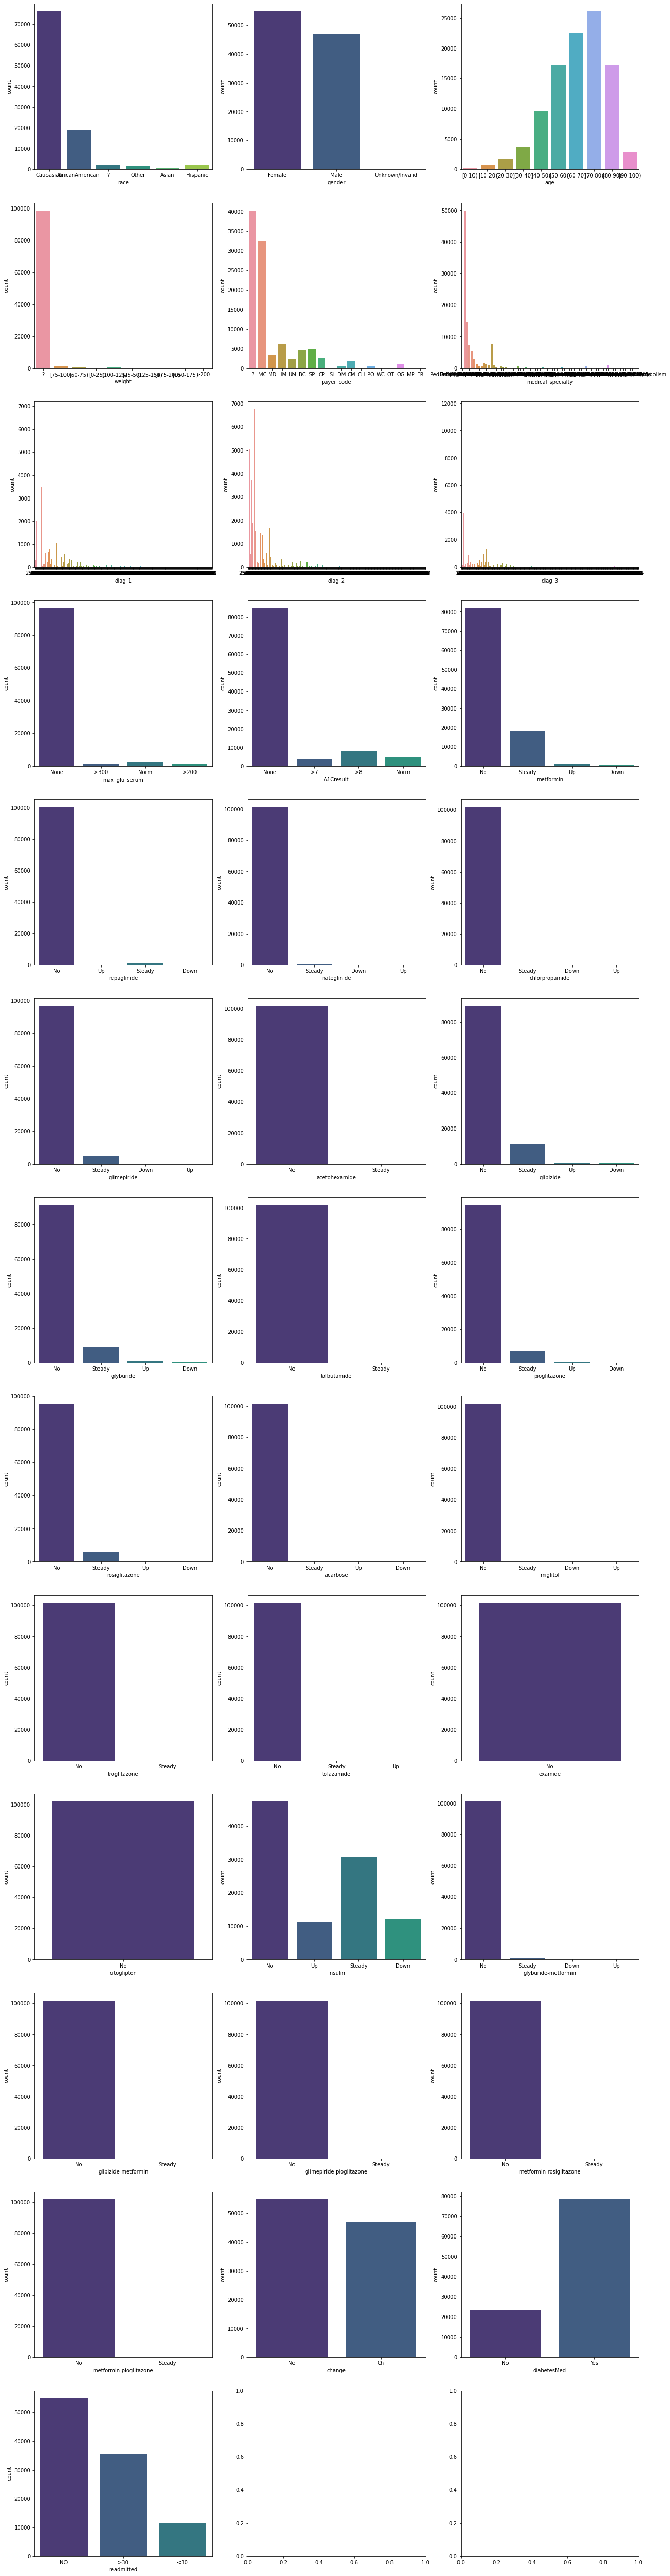

In [7]:
# plot the count plot of each categorical variable

# create the correct number of subplots
num_plots = len(categoricals)
total_cols = 3
total_rows = num_plots//total_cols +1

fig, axes = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows))

# use enumerate to plot each variable in the correct subplot position
for i, var in enumerate(categoricals):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.countplot(x=var, data=df, ax=axes[row][pos])

At a glance, there are clearly some categorical values with very few differences among the dataset, especially for the drug columns. Some even have all the same values for every row, which won't be helpful to include in our model.

There are also some variables with a large amount of potential categories--it isn't practical to add all of these categories to our model as dummy variables, so we will need to group these categories before feeding into our model. This will need to be done for all 3 diagnoses variables.

Our dependent variable in this analysis is in the 'readmitted' column--our model is trying to predict whether or not a patient will be readmitted. Although we have data for whether or not a patient is admitted within 30 days or outside of 30 days, this distinguishment isn't all that helpful for our analysis, so we will later group both types of readmissions together. It does not matter to the hospital if the patient is readmitted within or outside of 30 days; the hospital will still pay the price for the care.

In [8]:
# put remaining variables into continuous list
continuous = []
for col in df.columns:
    if col not in categoricals:
        continuous.append(col)

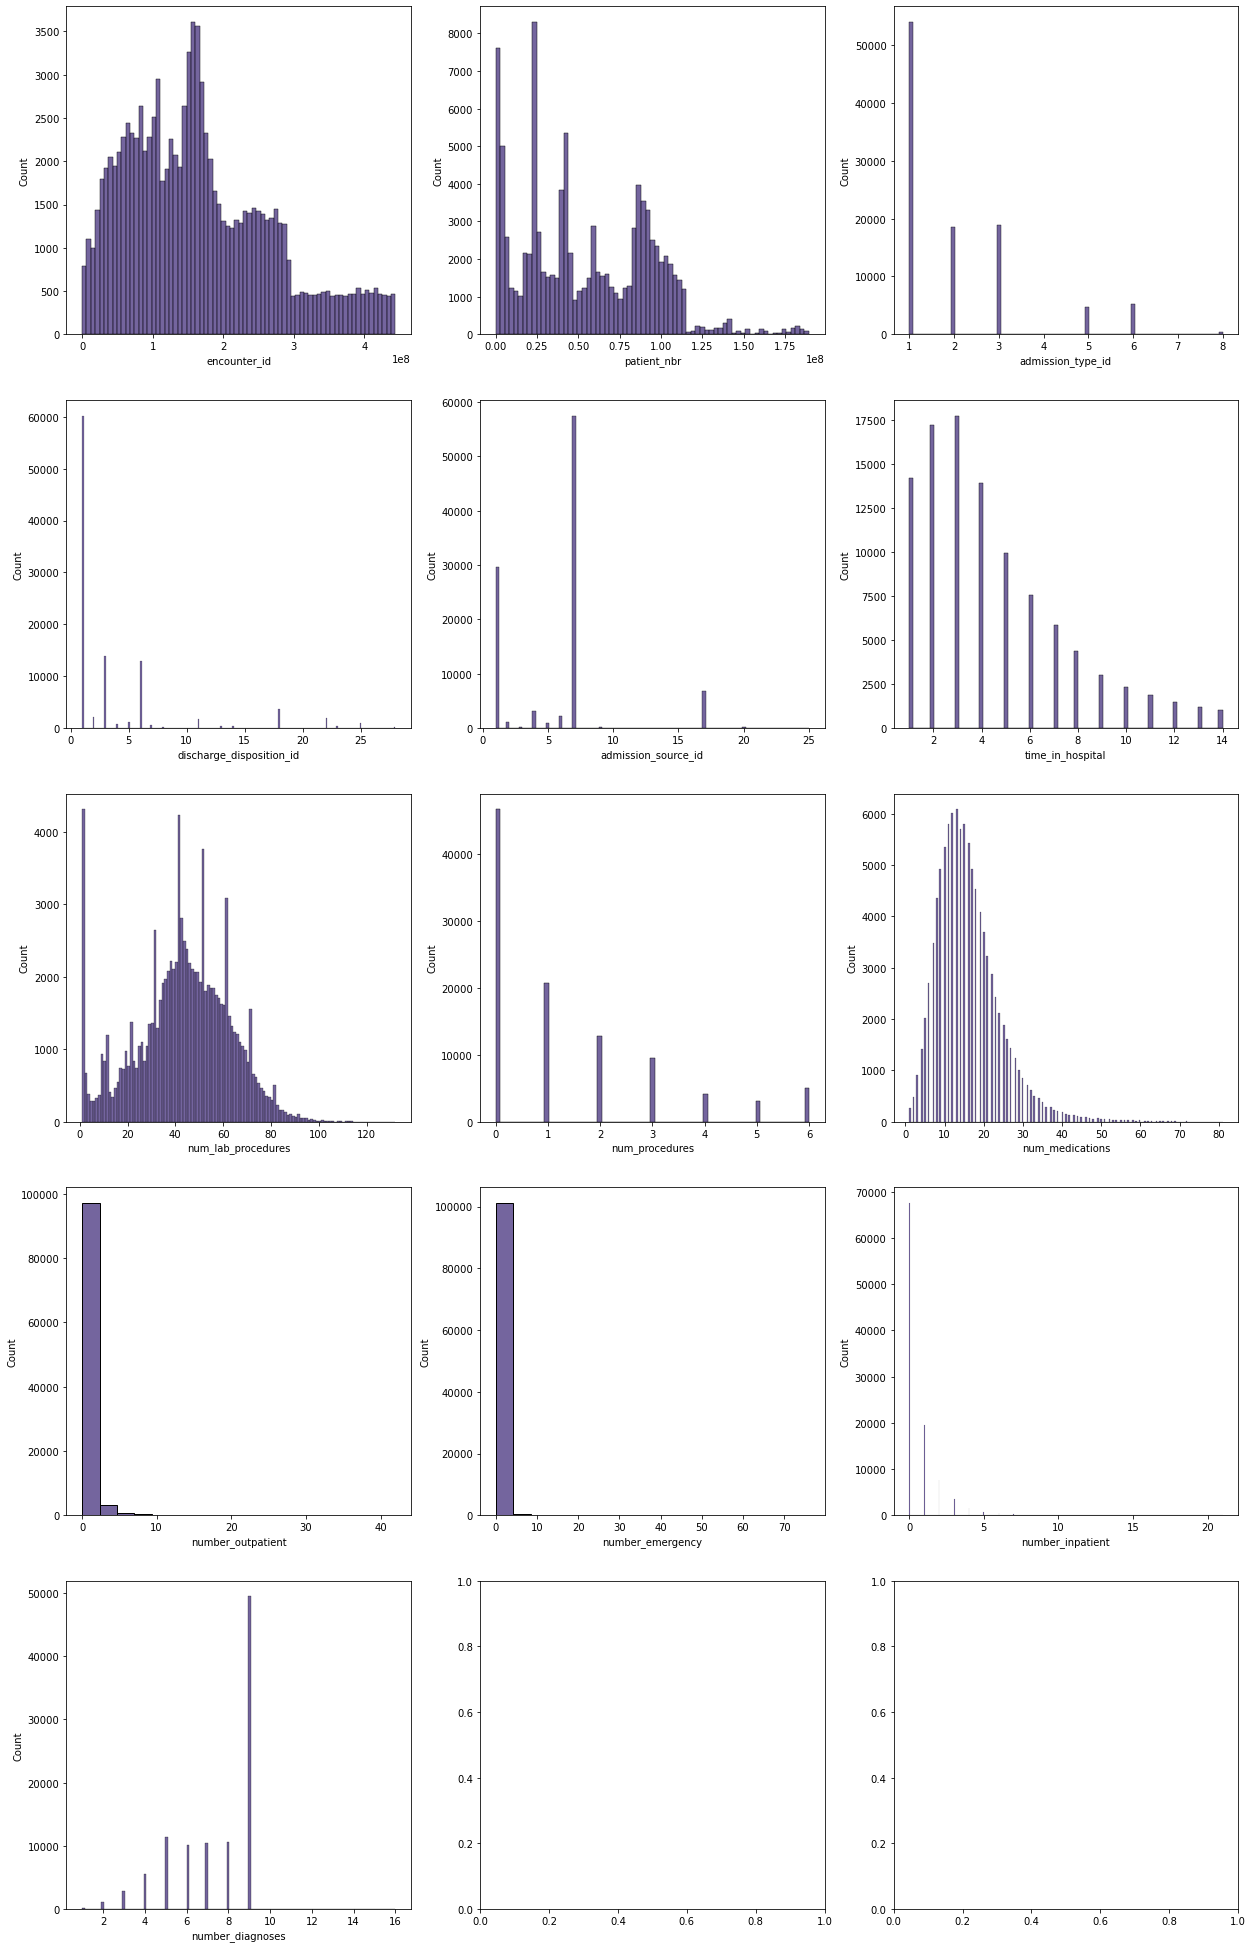

In [9]:
# plot the histogram of each continuous variable

# create the correct number of subplots
num_plots = len(continuous)
total_cols = 3
total_rows = num_plots//total_cols +1

fig, axes = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows))

# use enumerate to plot each variable in the correct subplot position
for i, var in enumerate(continuous):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.histplot(x=var, data=df, ax=axes[row][pos])

Although there are number values for the variables admission type id, discharge disposition id and admission source id, there are only a handful of values for each of these variables, and the numbers really stand for a category. It may be best to change the values of these variables to a handful of categorical options.

It looks like there may also be some potential outliers in our continuous variables, such as number_outpatient, number_emergency and number_inpatient.

## Explore Top Values for Each Variable

In [10]:
# check the top values of each column

for col in df.columns:
    print(df[col].value_counts(normalize=True)[:10])
    print('--------------------------------------')

96210942     0.00001
89943846     0.00001
384306986    0.00001
94650156     0.00001
83156784     0.00001
2674482      0.00001
281345844    0.00001
193616274    0.00001
355508024    0.00001
165973818    0.00001
Name: encounter_id, dtype: float64
--------------------------------------
88785891    0.000393
43140906    0.000275
23199021    0.000226
1660293     0.000226
88227540    0.000226
23643405    0.000216
84428613    0.000216
92709351    0.000206
23398488    0.000197
90609804    0.000197
Name: patient_nbr, dtype: float64
--------------------------------------
Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64
--------------------------------------
Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: gender, dtype: float64
--------------------------------------
[70-80)     0.256156
[60-70)     0.220928
[50-6

The first thing we noticed in our top 10 value counts is that 97% of the values for weight are question marks. This won't be very useful to us, so let's drop the weight column. 39% of the values for payer code are question marks and 49% are question marks for medical_speciality, so let's also drop these columns. There may be other question marks hiding in our data, so we will need to convert these ? to NAN values so we can easily find these values.

## Handle Missing Values

In [11]:
# convert all "?" to NAN so to easily find missing values

df = df.replace("?", np.nan)
df.isna().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [12]:
# drop columns with too many missing values
df.drop(columns=['weight', 'payer_code','medical_specialty'], inplace=True)
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Next, let's deal with the rows with missing values. We will drop all rows with missing values and also account for the unknown gender rows.

In [13]:
# drop any rows with missing values
df.dropna(axis=0, inplace=True)

# drop rows with unknown/invalid gender
df.drop(df[df['gender']=='Unknown/Invalid'].index, inplace=True)

In [14]:
# confirm missing values have been handled
df.isna().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol  

## Age

In the dataset, age is a categorical variable that represents a 10-year period of a patient's age. To try to improve our model, we are going to convert these categories back into a discrete continuous number to try to improve the performance of our model.

In [15]:
# create function that converts a range to a random integer within that range
def convert_age(low, high):
    age = np.random.randint(low, high)
    return age

In [16]:
# create a dictionary to put age variables in correct format to use convert_age function
age_dict = {'[70-80)':(70,80),
        '[60-70)': (60,70),
        '[80-90)': (80,90),
        '[50-60)': (50,60),
        '[40-50)': (40,50),
        '[30-40)': (30,40),
        '[90-100)': (90,100),
        '[20-30)': (20,30),
        '[10-20)': (10,20),
        '[0-10)': (0,10)}

# convert age values using dictionary
df['age'] = df['age'].map(age_dict)

# use convert_age function on each age range
df['age'] = df['age'].map(lambda x: convert_age(x[0], x[1]))

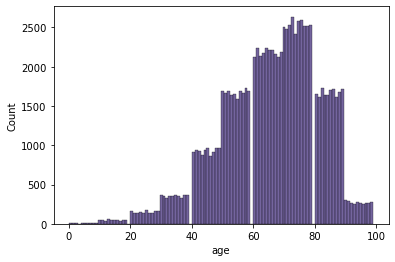

In [17]:
# confirm age values have been converted
sns.histplot(x='age', data=df);

Let's now deal with the diagnosis code columns, since these are categorical variables that will need to be binned.

## Diagnosis Codes

In [18]:
print(f'There are {df.diag_1.nunique()} diagnosis 1 categories.')
print(f'There are {df.diag_2.nunique()} diagnosis 2 categories.')
print(f'There are {df.diag_3.nunique()} diagnosis 3 categories.')

There are 713 diagnosis 1 categories.
There are 740 diagnosis 2 categories.
There are 786 diagnosis 3 categories.


There are over 700 unique values for diagnosis codes, which represent different ICD-9 codes. ICD-9 codes can be categorized into broader categories--we are going to recode the ICD-9 codes into these 9 broader categories.

In [19]:
# create a function for converting ICD codes

def diag_category(df, cols):
    for col in cols: 
        df.loc[(df[col].str.contains("V")) | (df[col].str.contains("E")), col] = -1
        df[col] = df[col].astype(np.float)
        
    for col in cols:
        df['diagnosis'] = np.nan
        df.loc[(df[col]>=390) & (df[col]<=459) | (df[col]==785), "diagnosis"] = "circulatory"
        df.loc[(df[col]>=460) & (df[col]<=519) | (df[col]==786), "diagnosis"] = "respiratory"
        df.loc[(df[col]>=520) & (df[col]<=579) | (df[col]==787), "diagnosis"] = "digestive"
        df.loc[(df[col]>=580) & (df[col]<=629) | (df[col]==788), "diagnosis"] = "genitourinary"
        df.loc[(df[col]>=240) & (df[col]<=279), "diagnosis"] = "endocrine"
        df.loc[(df[col]>=800) & (df[col]<=999), "diagnosis"] = "injury"
        df.loc[(df[col]>=710) & (df[col]<=739), "diagnosis"] = "musculoskeletal"
        df.loc[(df[col]>=140) & (df[col]<=239), "diagnosis"] = "neoplasms"
#         df.loc[(df[col]>=280) & (df[col]<=289), "diagnosis"] = "blood"
#         df.loc[(df[col]>=290) & (df[col]<=319), "diagnosis"] = "mental"
#         df.loc[(df[col]>=320) & (df[col]<=389), "diagnosis"] = "nervous"
        
        df["diagnosis"] = df["diagnosis"].fillna("Other")
        df[col] = df["diagnosis"]
        df = df.drop("diagnosis", axis=1)
    return df

In [20]:
df = diag_category(df,["diag_1","diag_2","diag_3"])

In [21]:
df.diag_1.value_counts()

circulatory        29629
Other              14949
respiratory        13993
endocrine          10557
digestive           9187
injury              6703
genitourinary       4983
musculoskeletal     4739
neoplasms           3312
Name: diag_1, dtype: int64

## Drug Categories

Let's now revisit the columns in our dataset that provide the patient's drug information. In the vast majority of cases, the drug was provided to less than 1% of patients. It will be very difficult to determine any sort of relationship between these drugs and hospital readmits, since so few patients received the drug. Since we are already going to have a high number of categorical columns based on other factors, we are going to drop the columns where less than 1% of patients received a drug.

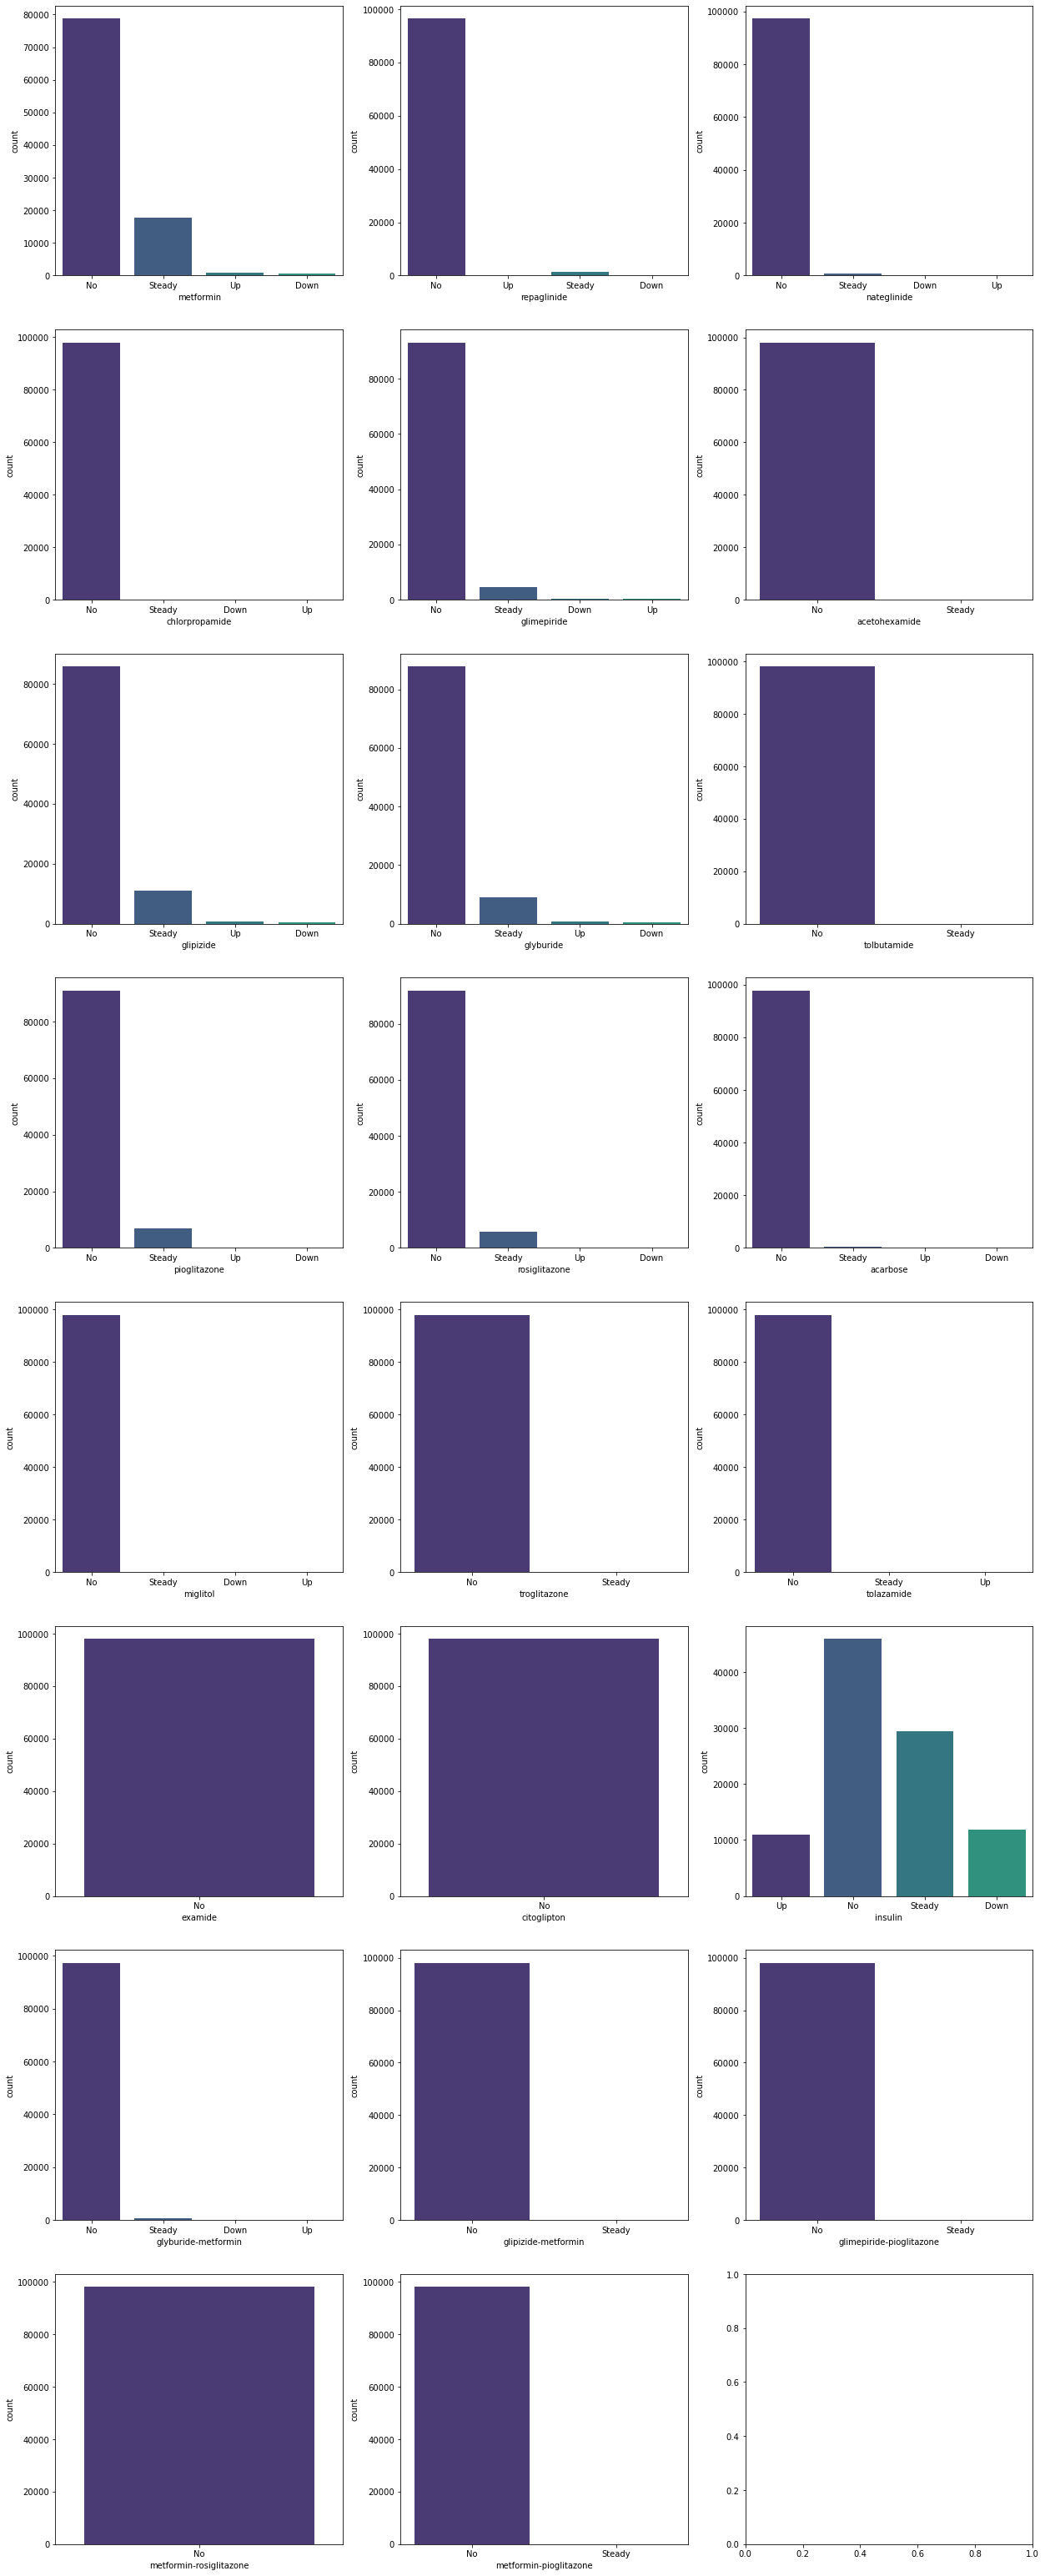

In [22]:
# put all drug variables into a list
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
         'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 
         'pioglitazone','rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
         'tolazamide', 'examide', 'citoglipton', 'insulin',
         'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
         'metformin-rosiglitazone', 'metformin-pioglitazone']

# visualize distribution of drug categories
num_plots = len(drugs)
total_cols = 3
total_rows = num_plots//total_cols +1

fig, axes = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows))


for i, var in enumerate(drugs):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.countplot(x=var, data=df, ax=axes[row][pos])

In [23]:
# put drug variables to remove into a list
drugs_to_remove = ['nateglinide', 'chlorpropamide','acetohexamide', 
                 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone',
                'tolazamide', 'examide','citoglipton', 'glyburide-metformin',
                'glipizide-metformin','glimepiride-pioglitazone',
                'metformin-rosiglitazone', 'metformin-pioglitazone']

df.drop(columns=drugs_to_remove, inplace=True)

In [24]:
# update list of drugs to only include remaining columns
drugs = [drug for drug in drugs if drug not in drugs_to_remove]

Now that we've taken a first pass through the drug information, let's explore the remaining drug features we have and if any further changes need to be made.

In [25]:
drugs

['metformin',
 'repaglinide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'insulin']

In [26]:
for col in df[drugs]:
    print(df[col].value_counts(normalize=True)[:5])
    print('--------------------------------------')

No        0.803727
Steady    0.180282
Up        0.010372
Down      0.005619
Name: metformin, dtype: float64
--------------------------------------
No        0.984467
Steady    0.013982
Up        0.001091
Down      0.000459
Name: repaglinide, dtype: float64
--------------------------------------
No        0.949139
Steady    0.045772
Up        0.003213
Down      0.001877
Name: glimepiride, dtype: float64
--------------------------------------
No        0.874730
Steady    0.112083
Up        0.007669
Down      0.005517
Name: glipizide, dtype: float64
--------------------------------------
No        0.895351
Steady    0.091095
Up        0.008067
Down      0.005487
Name: glyburide, dtype: float64
--------------------------------------
No        0.927620
Steady    0.068892
Up        0.002315
Down      0.001173
Name: pioglitazone, dtype: float64
--------------------------------------
No        0.937115
Steady    0.060254
Up        0.001775
Down      0.000857
Name: rosiglitazone, dtype: float64

When converting these drugs into categorical variables, keeping all of these categories would cause 32 new columns to be added to our dataframe. With the exception of insulin, the vast majority of patients are not prescribed these drugs. Instead of keeping 4 categories for each drug, let's recode these values into 0 if not prescribed the drug and 1 if a patient is prescribed the drug (whether steady, up or down). We will leave in the categories for insulin, since more than half of patients are prescribed insulin.

In [27]:
# use dictionary to turn drug categories into binary values
drugs.remove('insulin')
drug_dict = {'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1}
for col in df[drugs]:
    df[col] = df[col].map(drug_dict)

# confirm columns were updated
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,13,1,1,7,3,59,...,0,0,0,0,0,0,Up,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,21,1,1,7,2,11,...,0,0,1,0,0,0,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,31,1,1,7,2,44,...,0,0,0,0,0,0,Up,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,42,1,1,7,1,51,...,0,0,1,0,0,0,Steady,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,56,2,1,2,3,31,...,0,0,0,0,0,0,Steady,No,Yes,>30


We can also encode 'change' and 'diabetesMed' to be binary variables.

In [28]:
dict = {'No': 0, 'Ch': 1, 'Yes': 1}

df['change'] = df['change'].map(dict)
df['diabetesMed'] = df['diabetesMed'].map(dict)

# confirm columns were updated
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,13,1,1,7,3,59,...,0,0,0,0,0,0,Up,1,1,>30
2,64410,86047875,AfricanAmerican,Female,21,1,1,7,2,11,...,0,0,1,0,0,0,No,0,1,NO
3,500364,82442376,Caucasian,Male,31,1,1,7,2,44,...,0,0,0,0,0,0,Up,1,1,NO
4,16680,42519267,Caucasian,Male,42,1,1,7,1,51,...,0,0,1,0,0,0,Steady,1,1,NO
5,35754,82637451,Caucasian,Male,56,2,1,2,3,31,...,0,0,0,0,0,0,Steady,0,1,>30


## Admission and Discharge Type

The columns admission_type_id, discharge_disposition_id and admission_source_id are nominal values that stand for different classifications of admissions and discharges. Instead of leaving these values as numbers, since they are actually categorical, let's rename them to what each actually means. Note: we are going to use broader categories than provided to make our dataset easier to work with.

In [29]:
# create dictionary to recode admit ids

admit_dict = {1:'emergency', 2:'emergency', 3:'elective', 4:'newborn', 5:'unknown', 
              6:'unknown', 7:'traumacenter', 8:'unknown'} 

df['admission_type_id'] = df['admission_type_id'].map(admit_dict)

In [30]:
# create dictionary to recode discharge ids
discharge_dict = {}

discharge_dict = dict.fromkeys([1,6,7,8,13], 'home')
discharge_dict.update(dict.fromkeys([2,3,4,5,10,14,15,16,17,22,23,24,30,27,28,29], 'transfer'))
discharge_dict.update(dict.fromkeys([9,12], 'not_discharged'))
discharge_dict.update(dict.fromkeys([11,19,20,21], 'death'))
discharge_dict.update(dict.fromkeys([18,25,26], 'unknown'))


df['discharge_disposition_id'] = df['discharge_disposition_id'].map(discharge_dict)

In [31]:
# create dictionary to recode admission source ids
admit_source_dict = {}

admit_source_dict = dict.fromkeys([1,2,3,8,13], 'referral')
admit_source_dict.update(dict.fromkeys([7], 'emergency'))
admit_source_dict.update(dict.fromkeys([4,5,6,8,9,10,11,12,13,14,15,
                                        16,17,18,19,20,21,22,23,24,25,26], 'other'))


df['admission_source_id'] = df['admission_source_id'].map(admit_source_dict)

In [32]:
#confirm columns were updated
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,13,emergency,home,emergency,3,59,...,0,0,0,0,0,0,Up,1,1,>30
2,64410,86047875,AfricanAmerican,Female,21,emergency,home,emergency,2,11,...,0,0,1,0,0,0,No,0,1,NO
3,500364,82442376,Caucasian,Male,31,emergency,home,emergency,2,44,...,0,0,0,0,0,0,Up,1,1,NO
4,16680,42519267,Caucasian,Male,42,emergency,home,emergency,1,51,...,0,0,1,0,0,0,Steady,1,1,NO
5,35754,82637451,Caucasian,Male,56,emergency,home,referral,3,31,...,0,0,0,0,0,0,Steady,0,1,>30


## Readmission Data

As we mentioned above, the dataset groups our readmits into two different categories: a readmit in less than 30 days and a readmit in more than 30 days. The timing of the readmission isn't incredibly important to our client; they are more concerned with stopping readmissions altogether. Since we are only interested in whether or not there is a readmission, we are going to recode our dependent variable to create a binary classification problem.

In [33]:
df['readmitted'] = df.readmitted.replace({"NO":0,
                         "<30":1, ">30":1})
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,13,emergency,home,emergency,3,59,...,0,0,0,0,0,0,Up,1,1,1
2,64410,86047875,AfricanAmerican,Female,21,emergency,home,emergency,2,11,...,0,0,1,0,0,0,No,0,1,0
3,500364,82442376,Caucasian,Male,31,emergency,home,emergency,2,44,...,0,0,0,0,0,0,Up,1,1,0
4,16680,42519267,Caucasian,Male,42,emergency,home,emergency,1,51,...,0,0,1,0,0,0,Steady,1,1,0
5,35754,82637451,Caucasian,Male,56,emergency,home,referral,3,31,...,0,0,0,0,0,0,Steady,0,1,1


Let's quickly check for multicollinearity among features before continuing.

In [34]:
df_pairs=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_pairs['pairs'] = list(zip(df_pairs.level_0, df_pairs.level_1))

# set index to pairs
df_pairs.set_index(['pairs'], inplace = True)

# drop level columns
df_pairs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc 
df_pairs.columns = ['cc']

# drop duplicates
df_pairs.drop_duplicates(inplace=True)

#check for correlation between .75 and 1
df_pairs[(df_pairs.cc>.75) & (df_pairs.cc <1)]

,cc
pairs,


Now that the initial data cleaning is complete, we can begin converting our categorical variables to dummy variables.

## Convert Categorical to Dummy Variables

In [35]:
# use get_dummies to convert categorical columns into dummy variables
df_clean = pd.get_dummies(df, drop_first=True)

In [36]:
df_clean

,encounter_id,patient_nbr,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,diag_3_respiratory,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_No,insulin_Steady,insulin_Up
1,149190,55629189,13,3,59,0,18,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,64410,86047875,21,2,11,5,13,2,0,1,...,0,0,1,0,0,1,0,1,0,0
3,500364,82442376,31,2,44,1,16,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4,16680,42519267,42,1,51,0,8,0,0,0,...,0,0,1,0,0,1,0,0,1,0
5,35754,82637451,56,3,31,6,16,0,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,76,3,51,0,16,0,0,0,...,0,0,1,0,1,0,0,0,0,0
101762,443847782,74694222,85,5,33,3,18,0,0,1,...,0,0,1,0,0,1,0,0,1,0
101763,443854148,41088789,73,1,53,0,9,1,0,0,...,0,0,1,0,0,1,0,0,0,0
101764,443857166,31693671,87,10,45,2,21,0,0,1,...,0,0,1,0,0,1,0,0,0,1


Our dataframe now has 78 columns including all dummy variables.

In [37]:
df_clean.columns

Index(['encounter_id', 'patient_nbr', 'age', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'metformin', 'repaglinide', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'change',
       'diabetesMed', 'readmitted', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_Male',
       'admission_type_id_emergency', 'admission_type_id_newborn',
       'admission_type_id_traumacenter', 'admission_type_id_unknown',
       'discharge_disposition_id_home',
       'discharge_disposition_id_not_discharged',
       'discharge_disposition_id_transfer', 'discharge_disposition_id_unknown',
       'admission_source_id_other', 'admission_source_id_referral',
       'diag_1_circulatory', 'diag_1_digestive', 'diag_1_endocrine',
       'diag_1_genitourinary', 'diag_1_injury', 'diag_1_musculoskeletal',
       'diag_1_n

Let's fix the names of the columns to not have special characters, since this could be problematic for our modeling down the line.

In [38]:
df_clean.columns = [c.replace('>','_') for c in df_clean.columns]
df_clean.columns

Index(['encounter_id', 'patient_nbr', 'age', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'metformin', 'repaglinide', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'change',
       'diabetesMed', 'readmitted', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_Male',
       'admission_type_id_emergency', 'admission_type_id_newborn',
       'admission_type_id_traumacenter', 'admission_type_id_unknown',
       'discharge_disposition_id_home',
       'discharge_disposition_id_not_discharged',
       'discharge_disposition_id_transfer', 'discharge_disposition_id_unknown',
       'admission_source_id_other', 'admission_source_id_referral',
       'diag_1_circulatory', 'diag_1_digestive', 'diag_1_endocrine',
       'diag_1_genitourinary', 'diag_1_injury', 'diag_1_musculoskeletal',
       'diag_1_n

# Explore

## Readmitted - Dependent Variable

In this project, readmitted is going to be our target variable (y value). Let's plot this variable to get a sense for its distribution.

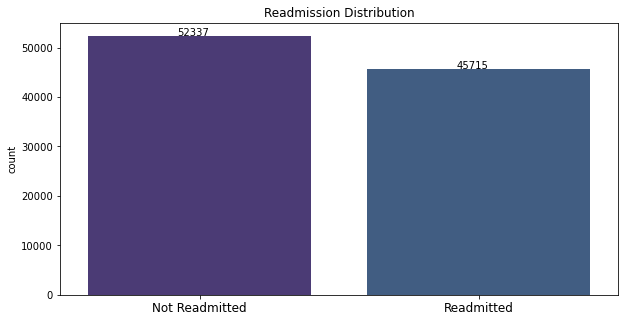

In [66]:
x_label = ''

fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x = 'readmitted', data = df)
ax.set(xlabel=x_label)
ax.set_xticklabels(['Not Readmitted', 'Readmitted'], fontsize=12)

for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = p.get_x() + width/2.5, 
            y = (height+.2),
            s = height) 

plt.title('Readmission Distribution', fontsize=12)
plt.savefig('images/readmissions.png')

We have slightly more values that are not readmitted versus readmitted. We will need to keep this class imbalance in mind when running our models.

In [40]:
# ax = df_clean['readmitted'].value_counts().sort_values().plot(kind="barh")
# totals= []
# for i in ax.patches:
#     totals.append(i.get_width())
# total = sum(totals)
# for i in ax.patches:
#      ax.text(i.get_width()+.3, i.get_y()+.20, 
#      str(round((i.get_width()/total)*100, 2))+'%', 
#      fontsize=10, color='black')
# plt.title('Readmitted Value Counts')
# plt.show()

## Gender vs. Readmitted

In [41]:
# x_label = 'Gender'

# fig = plt.figure(figsize=(10,5))
# ax = sns.countplot(x = 'gender', data = df, hue='readmitted')
# ax.set(xlabel=x_label)

# legend_labels, _= ax.get_legend_handles_labels()
# ax.legend(legend_labels, ['Not Readmitted','Readmitted'])
# plt.title(f'{x_label} vs. Readmission');

## Age vs. Readmitted

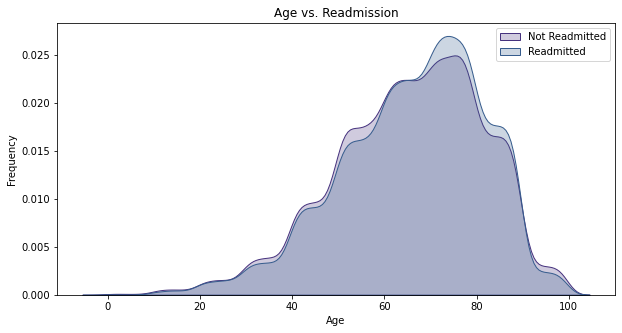

In [42]:
fig = plt.figure(figsize=(10,5))
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'age'],shade=True,label='Not Readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'age'],shade=True, label='Readmitted')
ax.set(xlabel='Age', ylabel='Frequency')
ax.legend()
plt.title('Age vs. Readmission');

It appears that as age increases above 65, it becomes much more likely that a patient will be readmitted. After about age 90, the probability of being readmitted decreases, likely due to death being more likely.

## Time in Hospital vs. Readmitted

In [43]:
# x_label = 'Time in Hospital'

# fig = plt.figure(figsize=(10,5))
# ax = sns.countplot(x = 'time_in_hospital', data = df_clean, hue='readmitted')
# ax.set(xlabel=x_label)

# legend_labels, _= ax.get_legend_handles_labels()
# ax.legend(legend_labels, ['Not Readmitted','Readmitted'])
# plt.title(f'{x_label} vs. Readmission');

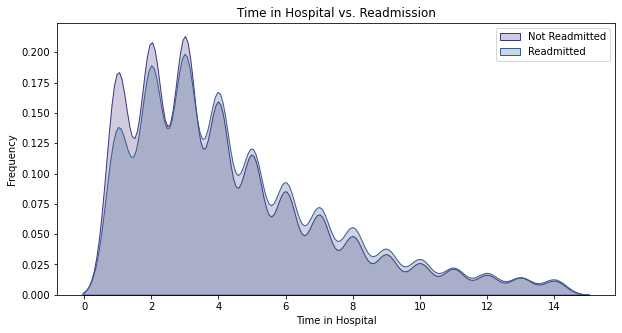

In [44]:
fig = plt.figure(figsize=(10,5))
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'time_in_hospital'],shade=True,label='Not Readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'time_in_hospital'],shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
ax.legend()
plt.title('Time in Hospital vs. Readmission');

It appears the more days a patient stays in the hospital, the more likely they are to be readmitted. After 3 days in the hospital, it is more likely that a patient would be readmitted rather than not.

## Number of Diagnoses vs. Readmitted

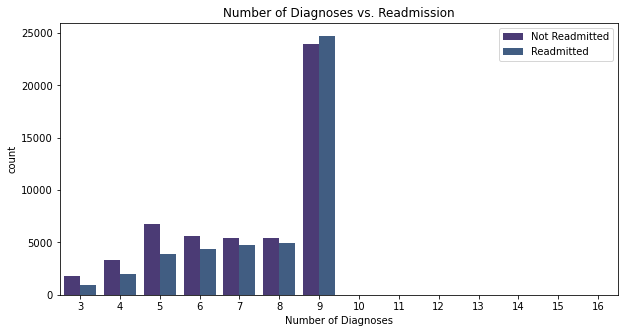

In [45]:
x_label = 'Number of Diagnoses'

fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x = 'number_diagnoses', data = df_clean, hue='readmitted')
ax.set(xlabel=x_label)

legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Not Readmitted','Readmitted'])
plt.title(f'{x_label} vs. Readmission');

It also appears that as our number of diagnoses increases, so does the number of readmissions. Let's look closer at the trend under 10 diagnoses.

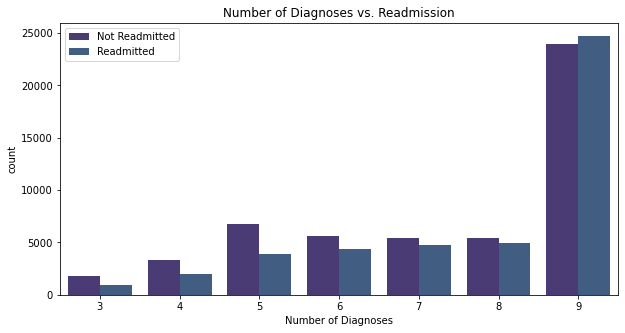

In [46]:
x_label = 'Number of Diagnoses'

fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x = 'number_diagnoses', 
                   data = df_clean[df_clean['number_diagnoses']<10], hue='readmitted')
ax.set(xlabel=x_label)

legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Not Readmitted','Readmitted'])
plt.title(f'{x_label} vs. Readmission');

There is a clear trend that as the number of diagnoses increases, it becomes more likely that the patient will be readmitted.

## Number of Medications vs. Readmitted

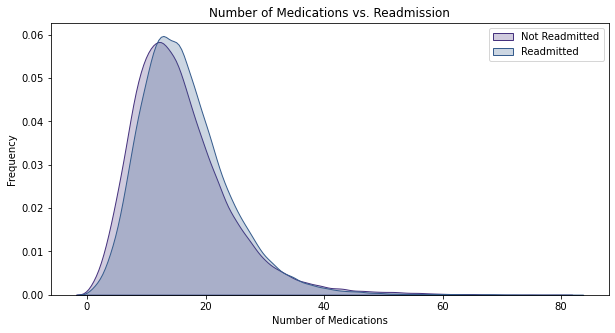

In [47]:
fig = plt.figure(figsize=(10,5))
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'num_medications'],shade=True,label='Not Readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'num_medications'],shade=True, label='Readmitted')
ax.set(xlabel='Number of Medications', ylabel='Frequency')
ax.legend()
plt.title('Number of Medications vs. Readmission');

After a patient is on more than approximately 10 medications, it becomes more likely the patient will be readmitted rather than not readmitted.

## Number of Lab Procedures vs. Readmitted

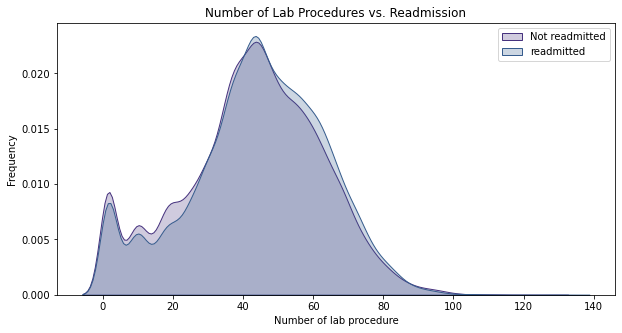

In [48]:
fig = plt.figure(figsize=(10,5))
ax=sns.kdeplot(df.loc[(df_clean['readmitted'] == 0),'num_lab_procedures'], shade=True, label='Not readmitted')
ax=sns.kdeplot(df.loc[(df_clean['readmitted'] == 1),'num_lab_procedures'], shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
ax.legend()
plt.title('Number of Lab Procedures vs. Readmission');

When a patient has fewer than 30 lab procedures, they are more likely to not be readmitted; after more than 40 lab procedures, it is more likely the patient will be readmitted.

## Discharge Reason vs. Readmits

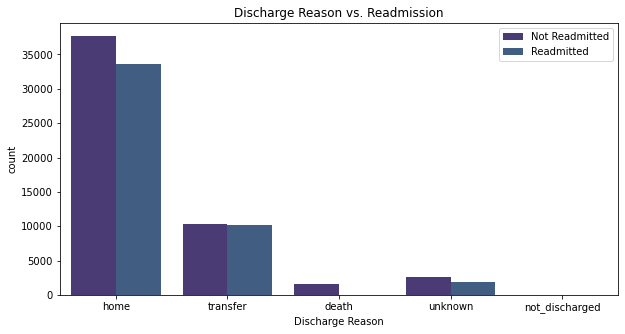

In [50]:
x_label = 'Discharge Reason'

fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x = 'discharge_disposition_id', 
                   data = df, hue='readmitted')
ax.set(xlabel=x_label)

legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Not Readmitted','Readmitted'])
plt.title(f'{x_label} vs. Readmission');

When a patient is discharged to home, it is more likely they will not be readmitted, while if a patient is transferred, it is just as likely the patient will be readmitted as if they will not be readmitted.

## Medication vs. Readmits

<Figure size 720x360 with 0 Axes>

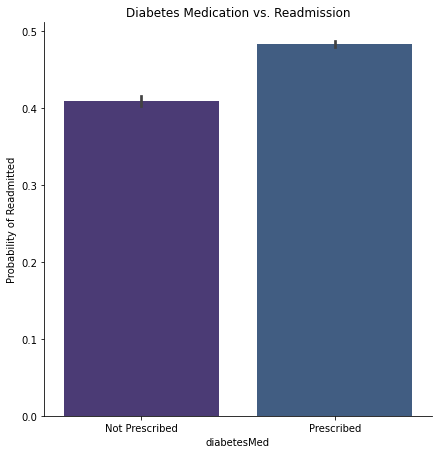

In [60]:
x_label = 'Diabetes Medication'
fig = plt.figure(figsize=(10,5))
ax = sns.catplot(x = "diabetesMed", y="readmitted", 
            data = df_clean, height = 6, kind ="bar")
ax.set_ylabels("Probability of Readmitted")
ax.set_xticklabels(['Not Prescribed', 'Prescribed'], fontsize=10)
plt.title(f'{x_label} vs. Readmission');
plt.show();

If a patient is on diabetes medication, the probability they will be readmitted is higher.

<Figure size 720x360 with 0 Axes>

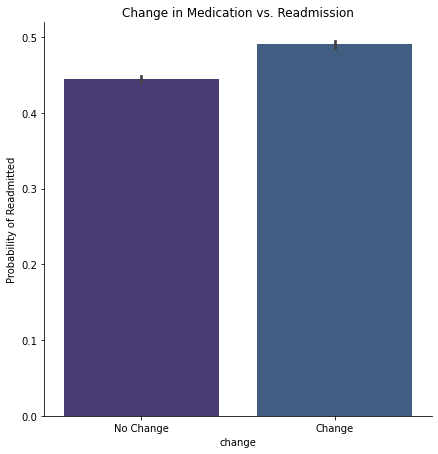

In [62]:
x_label = 'Change in Medication'
fig = plt.figure(figsize=(10,5))
ax = sns.catplot(x = "change", y="readmitted", 
            data = df_clean, height = 6, kind ="bar")
ax.set_ylabels("Probability of Readmitted")
ax.set_xticklabels(['No Change', 'Change'], fontsize=10)
plt.title(f'{x_label} vs. Readmission');
plt.show();

If there is a change in the patient's medication during their hospital stay, it is also more likely the patient will be readmitted.

<Figure size 720x360 with 0 Axes>

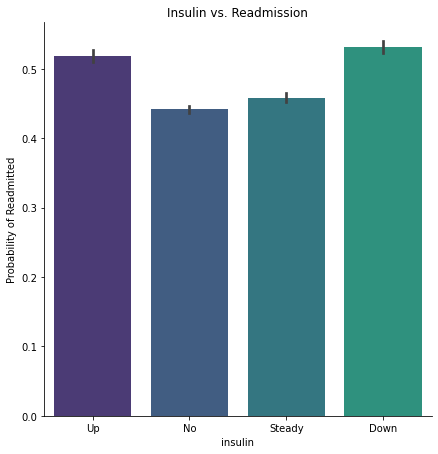

In [63]:
x_label = 'Insulin'
fig = plt.figure(figsize=(10,5))
ax = sns.catplot(x = "insulin", y="readmitted", 
            data = df, height = 6, kind ="bar")
ax.set_ylabels("Probability of Readmitted")

plt.title(f'{x_label} vs. Readmission');
plt.show();

It is more likely the patient will be readmitted if their insulin dosage was decreased or increased, compared to if their insulin was left steady or if the patient wasn't taking insulin.

## Export Clean Data

In [53]:
df_clean.to_csv('data/diabetes_data_clean.csv')

In the next notebook, we will create a number of classification models and analyze which model is best at predicting whether or not a diabetes patient will be readmitted to the hospital.